# Implémentation de la classe KMeans

In [34]:
import numpy as np
from scipy.spatial.distance import cdist

class myKMeans:
    def __init__(self, k=8, init='random', max_iter=300, tol=1e-4):
        self.k = k
        self.init = init
        self.max_iter = max_iter
        self.tol = tol
        self.centroids = None
        self.labels = None

    def fit(self, X):
        n_samples, n_features = X.shape
        if self.init == 'random':
            self.centroids = X[np.random.choice(n_samples, self.k, replace=False)]

        elif self.init == 'kmeans++':
            self.centroids = [X[np.random.choice(n_samples)]]
            while len(self.centroids) < self.k:
                dists = cdist(X, self.centroids)
                probs = np.min(dists, axis=1) ** 2
                probs /= np.sum(probs)
                idx = np.random.choice(n_samples, p=probs)
                self.centroids.append(X[idx])
            self.centroids = np.array(self.centroids)

        for _ in range(self.max_iter):
            distances = cdist(X, self.centroids)
            self.labels = np.argmin(distances, axis=1)
            new_centroids = np.zeros((self.k, n_features))
            for i in range(self.k):
                new_centroids[i] = X[self.labels == i].mean(axis=0)
            if np.abs(new_centroids - self.centroids).sum() < self.tol:
                break

            self.centroids = new_centroids

    def predict(self, X):
        distances = cdist(X, self.centroids)
        return np.argmin(distances, axis=1)


### Explication des optimisations

Cette implémentation du KMeans comprend 2 optimisations différentes destinées à améliorer ses performances sur des datasets de plus grande taille.

La première optimisation est l'ajout de cette variable 'tol' qui correspond au critère de tolérance, ce critère ou seuil de tolérance permet de définir la précision de convergence du modèle. En effet à chaque itération, le modèle va calculer la différence des positions des centroïdes de deux itérations successives, si cette valeur est inférieur à celle du critère de tolérance, on considère que le modèle a convergé permettant ainsi d'éviter des itérations 'inutiles'.
    
La seconde optimisation est l'ajout du kmeans++ pour l'initialisation des centroïdes. La méthode classique choisie les centroïdes de manière totalement aléatoire, ce qui peut donner de mauvais résultats. Par exemple si les centroïdes choisis se retrouvent tous être dans une zone dense d'observations celà peut conduire à une convergence prématurée sur un minimum local et fausser les résultats.
Cette initialisation kmeans++ choisie le premier centroïde de manière aléatoire. Les centroïdes suivants seront choisis avec la probabilité proportionnelle à la distance au carré de chaque observations par rapport aux centroïdes déjà choisis.
De cette manière on obtient après l'initialisation on obtient des centroïdes qui sont bien répartis dans l'espace de données et permet d'une part d'éviter la convergence vers un minimum local, et d'autre part de potentiellement réduire le nombre d'itération nécessaires pour arriver à la convergence, rendant le modèle plus rapide.

# Application et comparaison du modèle de scikit-learn et du notre

#### Ajout des librairies nécessaires

In [35]:
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans as KMeans_sklearn
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt

#### Chargement du dataset et création des variables pour les métrics de qualité

In [36]:
iris = load_iris()
X = iris.data

k_values = range(2, 7)

sklearn_scores = []
optimized_scores = []
sse_optimized = []
sse_sklearn = []

#### Lancement des deux modèles pour différentes valeurs de k

On lance les deux modèles pour plusieurs valeurs de k et on affiche le silhouette score ainsi que les clusters

KMeans avec 2 clusters:
	Scikit-learn score: 0.6810
	Optimized score: 0.6810


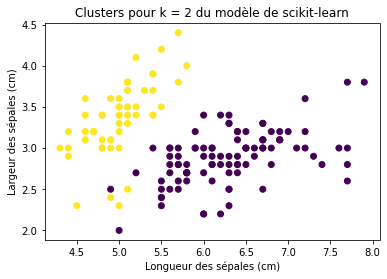

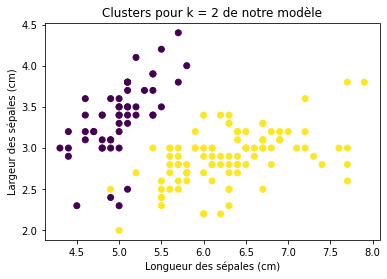

KMeans avec 3 clusters:
	Scikit-learn score: 0.5528
	Optimized score: 0.5512


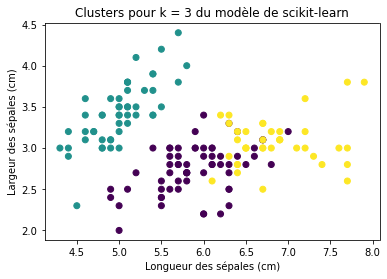

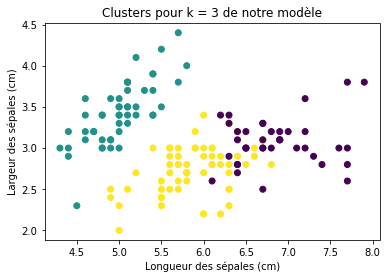

KMeans avec 4 clusters:
	Scikit-learn score: 0.4981
	Optimized score: 0.4090


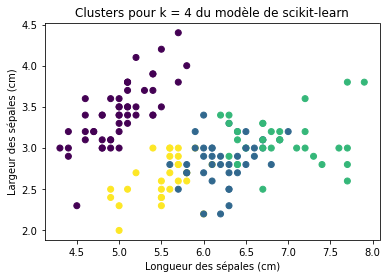

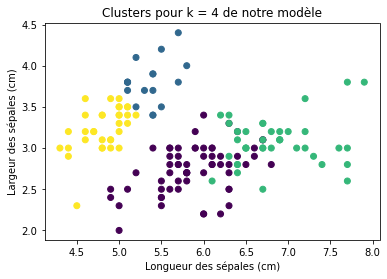

KMeans avec 5 clusters:
	Scikit-learn score: 0.4887
	Optimized score: 0.4500


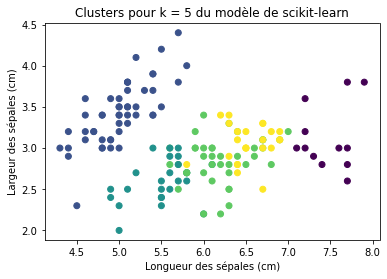

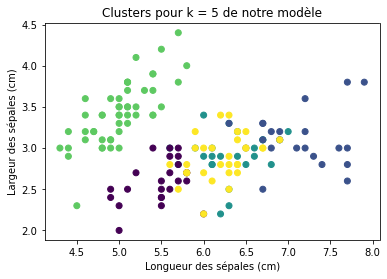

KMeans avec 6 clusters:
	Scikit-learn score: 0.3648
	Optimized score: 0.4328


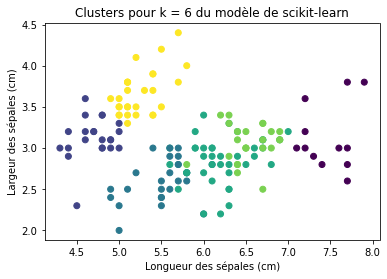

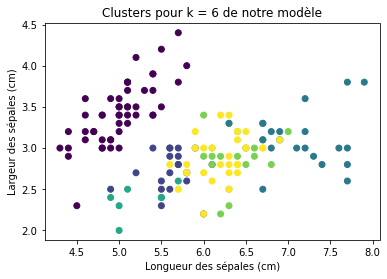

In [40]:
for k in k_values:
    kmeans_sklearn = KMeans_sklearn(n_clusters=k, random_state=42)
    kmeans_optimized = myKMeans(k=k, init='kmeans++', max_iter=300, tol=1e-4)

    kmeans_sklearn.fit(X)
    kmeans_optimized.fit(X)

    sklearn_score = silhouette_score(X, kmeans_sklearn.labels_)
    optimized_score = silhouette_score(X, kmeans_optimized.labels)

    sklearn_scores.append(sklearn_score)
    optimized_scores.append(optimized_score)
    sse_sklearn.append(kmeans_sklearn.inertia_)
    sse_optimized.append(np.sum((X - kmeans_optimized.centroids[kmeans_optimized.labels]) ** 2))
    
    print(f"KMeans avec {k} clusters:\n\tScikit-learn score: {sklearn_score:.4f}\n\tOptimized score: {optimized_score:.4f}")
    
    labels_optimized = kmeans_optimized.labels
    labels_sklearn = kmeans_sklearn.labels_
    
    plt.scatter(X[:, 0], X[:, 1], c=labels_sklearn)
    plt.title(f'Clusters pour k = {k} du modèle de scikit-learn')
    plt.xlabel('Longueur des sépales (cm)')
    plt.ylabel('Largeur des sépales (cm)')
    plt.show()
    plt.scatter(X[:, 0], X[:, 1], c=labels_optimized)
    plt.title(f'Clusters pour k = {k} de notre modèle')
    plt.xlabel('Longueur des sépales (cm)')
    plt.ylabel('Largeur des sépales (cm)')
    plt.show()

#### Affichage des métrics de qualité du clustering

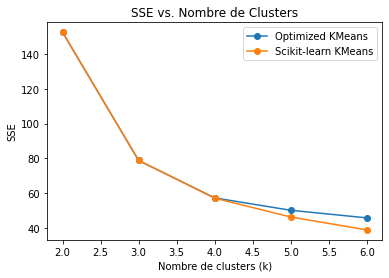

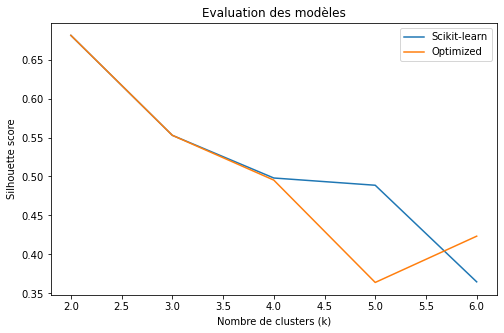

In [39]:
plt.plot(k_values, sse_optimized, '-o', label='Optimized KMeans')
plt.plot(k_values, sse_sklearn, '-o', label='Scikit-learn KMeans')
plt.xlabel('Nombre de clusters (k)')
plt.ylabel('SSE')
plt.title('SSE vs. Nombre de Clusters')
plt.legend()
plt.show()    

fig, ax = plt.subplots(figsize=(8, 5))

ax.plot(k_values, sklearn_scores, label="Scikit-learn")
ax.plot(k_values, optimized_scores, label="Optimized")

ax.set_xlabel("Nombre de clusters (k)")
ax.set_ylabel("Silhouette score")
ax.set_title("Evaluation des modèles")
ax.legend()
plt.show()